# Chapter 5
## Three Simple Models of Neurons in Rodent Brains
- Code by : [Abolfazl Ziaeemehr](https://github.com/Ziaeemehr)### Wang-Buzs´aki Model of an Inhibitory Interneuron in Rat Hippocampus

In [4]:
def plot_data(state_monitor, title=None, c='k'):
    """Plots the state_monitor variables "vm" vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(1, figsize=(10, 3))

    ax.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c=c)

    ax.set_xlabel("t [ms]")
    ax.set_ylabel("v [mV]")

    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        -100, 50))

    if title is not None:
        ax.set_title(title)

    plt.show();

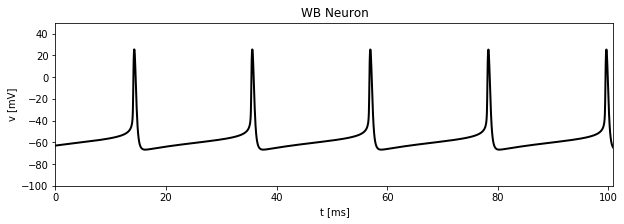

In [5]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory
from numpy import exp


def simulate_WB_neuron(input_current, simulation_time):

    """A Wang-Buszaki neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "n", "h"]
    """

    # neuron parameters
    El = -65 * b2.mV
    EK = -90 * b2.mV
    ENa = 55 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 9 * b2.msiemens
    gNa = 35 * b2.msiemens
    C = 1 * b2.ufarad

    # forming WB model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    
    alphah = 0.35 * exp(-(vm + 58.0*mV) / (20.0*mV))/ms :Hz
    alpham = 0.1/mV * (vm + 35.0*mV) / (1.0 - exp(-0.1/mV * (vm + 35.0*mV))) /ms :Hz
    alphan = -0.05/mV * (vm + 34.0*mV) / (exp(-0.1/mV * (vm + 34.0*mV)) - 1.0)/ms :Hz
    
    betah = 5.0 / (exp(-0.1/mV * (vm + 28.0*mV)) + 1.0)/ms :Hz
    betam = 4.0 * exp(-(vm + 60.0*mV) / (18.0*mV))/ms :Hz
    betan = 0.625 * exp(-(vm + 44.0*mV) / (80.0*mV))/ms :Hz
    
    m_inf = alpham / (alpham + betam) : 1
    
    membrane_Im = I_e + gNa*m_inf**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="rk4", dt=0.05*b2.ms)

    
    neuron.vm = -63*b2.mV
    neuron.h = "alphah / (alphah + betah)"
    neuron.n = "alphan / (alphan + betan)"

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

current = input_factory.get_step_current(0, 101, b2.ms, 0.75 * b2.uA)
state_monitor = simulate_WB_neuron(current, 101 * b2.ms)
plot_data(state_monitor, title="WB Neuron")